In [2]:
import os
import time
import collections

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression

In [4]:
from utils.td3 import Agent
from utils.pred import Predictor
from utils.envs import TradingEnv9
from utils.utilities import fetch_data, live_plot

In [5]:
import warnings

warnings.simplefilter('ignore')

In [6]:
%matplotlib inline

---

In [7]:
HOLDOUT = pd.to_datetime('2019-01-01')
REPORT = 50

In [8]:
env_name = 'TradingEnv9'
db_name = './data/HistoricalPriceData.db'

seed = 70

In [9]:
torch.manual_seed(seed)
np.random.seed(seed)

In [10]:
if not os.path.exists('./models'):
    os.makedirs('./models')
if not os.path.exists('./models/all_td3'):
    os.makedirs('./models/all_td3')

In [11]:
file_name = f'TD3_{env_name}_main_{seed}'
print(file_name)

TD3_TradingEnv9_main_70


---
---
---

### Non-Robust (Initialization) Training:

##### Fetch the data

In [12]:
data = fetch_data(db_name)

In [13]:
# Don't include 2020 shock
for tick in data:
    data[tick] = data[tick][
        data[tick]['date'] < HOLDOUT
    ]
    

In [14]:
size = 520 # About two years
idx = np.random.randint(0, len(data['fb'])-size)

for t in data:
    data[t] = data[t].iloc[idx: idx+size]
    data[t].reset_index(drop=True, inplace=True)
    

In [15]:
print(idx)

214


##### Initialize environment and set seeds

In [16]:
env = eval(f'{env_name}(data)')
env.seed(seed)

In [17]:
state_dim = np.prod(env.observation_space.shape)
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

##### Initialize agent parameters

In [18]:
buffer_size = 1e6
batch_size = 100

gamma = 0.99
tau = 5e-3
policy_freq = 2
lr = 1e-3

policy_noise = 0.2
noise_clip = 0.5
expl_noise = 0.15

##### Initialize agent

In [19]:
agent_state_dim = env.observation_space.shape[0] * (env.observation_space.shape[1]+1)

In [20]:
agent = Agent(
    state_dim=agent_state_dim, 
    action_dim=action_dim, 
    max_action=max_action,
    eta=lr,
)


##### Initialize predictor model

In [21]:
pred_input = (env.observation_space.shape[0]-1) * (env.observation_space.shape[1]-2)
pred_output = env.action_space.shape[0] - 1

In [22]:
predictor = Predictor(
    input_dim=pred_input, 
    output_dim=pred_output,
    eta=lr,
)


---

##### Initialize training variables 

In [23]:
starting_step = 2e4 # Number of random steps at start
init_thresh = 5 # When to stop initialization
episodes = 1e3 # Number of episodes to train on

total_steps = 0
training = False

In [24]:
positions = env.positions
reward_trace = collections.defaultdict(list)
ep = 1 # Starting episode

##### Training:

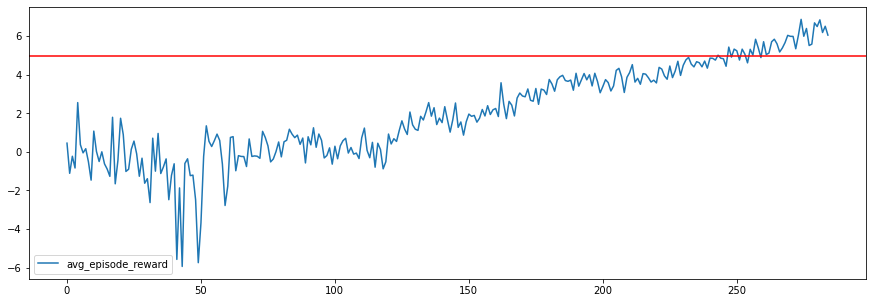

Episodes: 285
Steps: 147630
Average reward: 6.060120970272415


In [25]:
for ep in np.arange(ep, episodes):             
    
    obs = env.reset()
    done = False
    episode_reward = []
    steps = 0
        
    ##################################################
    
    while not done:    
        
        agent_obs = predictor.predict(obs)
        
        if total_steps == starting_step:
            print('Begin training')
            training = True
            
        if not training:
            action = env.action_space.sample()
        else:
            action = agent.select_action(agent_obs)
            
            if expl_noise != 0:
                noise = np.random.normal(0, expl_noise, size=env.action_space.shape[0])
                action = (action+noise).clip(env.action_space.low, env.action_space.high)
                
        action_fmt = env.format_action(positions, action)
                
        new_obs, reward, done, info = env.step(action_fmt)
        
        episode_reward.append(reward)
        predictor.commit(obs, new_obs)        
        
        agent_new_obs = predictor.predict(new_obs)
        agent.replay_buffer.add((agent_obs, agent_new_obs, action, reward, int(done)))
                
        obs = new_obs
        steps += 1
        total_steps += 1
        
    ##################################################
        
    agent.train(steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_freq)
    predictor.train(batch_size=batch_size)
    
    reward_trace['net_worth_diff'].append(sum(np.array(env.net_worth)-np.array(env.net_worth_long)))
    reward_trace['avg_episode_reward'].append(np.mean(episode_reward))
    reward_trace['sum_episode_reward'].append(sum(episode_reward))
    reward_trace['exploration_noise'].append(round(expl_noise, 9))
    
    ax = live_plot(reward_trace, trace='avg')
    plt.axhline(init_thresh, c='r')
    plt.show()
    
    if training and all(
        [i>=init_thresh for i in reward_trace['avg_episode_reward'][-REPORT//2:]]
    ):
        
        agent.save(
            f'{file_name}_init', 
            './models/all_td3',
        )
        
        predictor.save(
            f'{file_name}_init', 
            './models/all_td3',
        )
        
        print('Episodes:', int(ep))
        print('Steps:', total_steps)
        print('Average reward:', reward_trace['avg_episode_reward'][-1])
        
        break
        

##### Plot reward trace

In [26]:
nwd = pd.Series(reward_trace['net_worth_diff'])
nwd = nwd.rolling(window=REPORT, center=True, min_periods=1).mean()

print(np.argmax(nwd)+1, np.argmax(reward_trace['net_worth_diff'])+1)

285 50


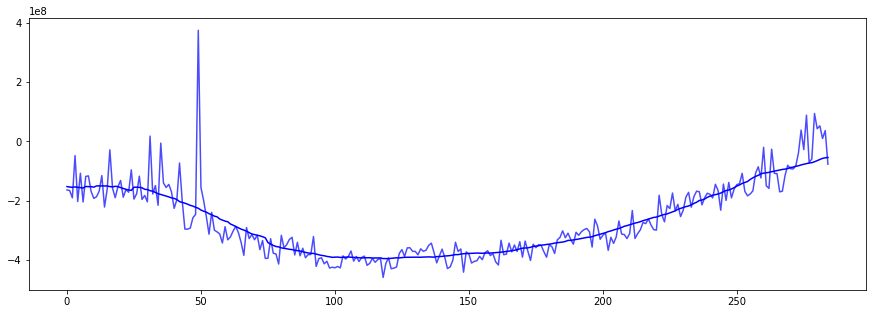

In [27]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['net_worth_diff'], 'b', alpha=0.7)
plt.plot(nwd, 'b')

plt.show()

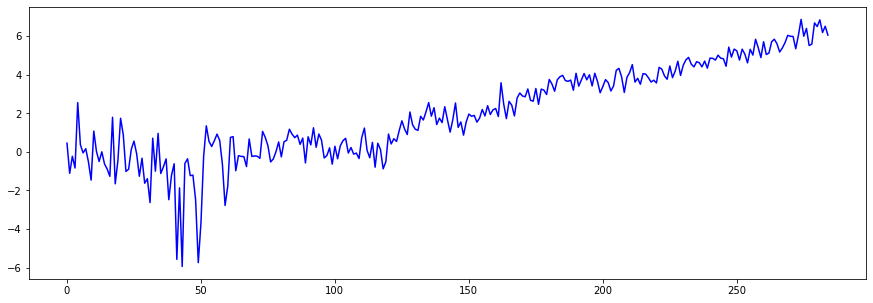

In [28]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['avg_episode_reward'], 'b')

plt.show()

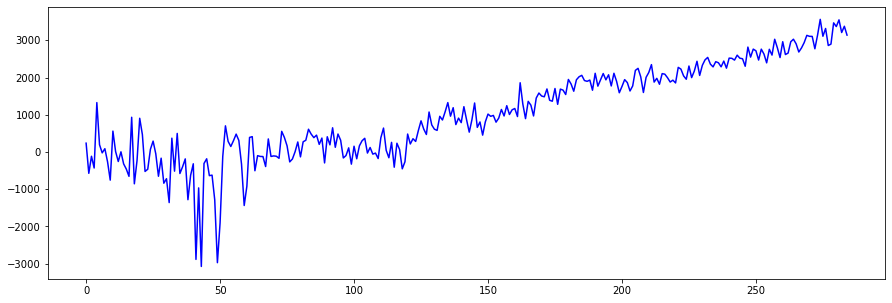

In [30]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['sum_episode_reward'], 'b')

plt.show()

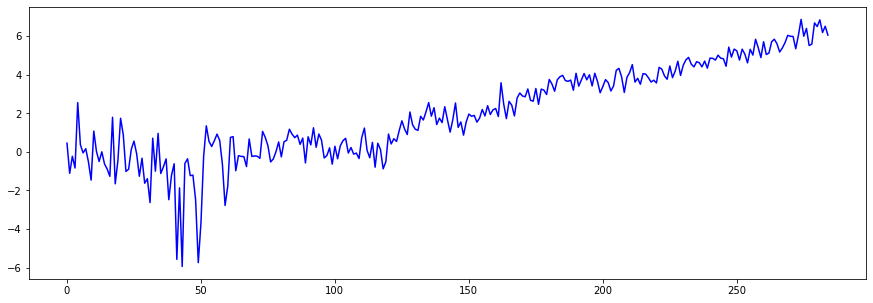

In [31]:
###
plt.figure(figsize=(15,5))
plt.plot(reward_trace['avg_episode_reward'], 'b')
plt.savefig('./repo_assets/01-15-2021') ###
plt.show()

---
---
---

### Robust Training:

##### Re-fetch the data

In [32]:
data = fetch_data(db_name)

In [33]:
for tick in data:

    # Holdout set
    data[tick] = data[tick][
        data[tick]['date'] < HOLDOUT
    ]
    
    data[tick].reset_index(drop=True, inplace=True)
    

##### Re-initialize environment and set seeds

In [34]:
env = eval(f'{env_name}(data)')

In [35]:
state_dim = np.prod(env.observation_space.shape)
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

##### Initialize new agent parameters

In [36]:
buffer_size = 1e6
batch_size = 100

gamma = 0.99
tau = 5e-3
policy_freq = 2
lr = 1e-3
reg = 1e-4

policy_noise = 0.2
noise_clip = 0.5
expl_noise = 0.15

##### Initialize agent

In [37]:
agent_state_dim = env.observation_space.shape[0] * (env.observation_space.shape[1]+1)

In [38]:
agent = Agent(
    state_dim=agent_state_dim, 
    action_dim=action_dim, 
    max_action=max_action,
    eta=lr,
    alpha=reg,
)


In [39]:
agent.load(
    f'{file_name}_init', 
    './models/all_td3',
)


##### Initialize predictor model

In [40]:
pred_input = (env.observation_space.shape[0]-1) * (env.observation_space.shape[1]-2)
pred_output = env.action_space.shape[0] - 1

In [41]:
predictor = Predictor(
    input_dim=pred_input, 
    output_dim=pred_output,
    eta=lr,
    alpha=reg,
)


In [42]:
predictor.load(
    f'{file_name}_init', 
    './models/all_td3',
)


---

##### Initialize training variables 

In [43]:
starting_step = 1e4 # Number of random steps at start

episodes = 1e3 # Number of episodes to train on
total_steps = 0
training = False

In [44]:
positions = env.positions
reward_trace = collections.defaultdict(list)
ep = 1 # Starting episode

In [45]:
size = 520
n_obs = env.n_obs

##### Training:

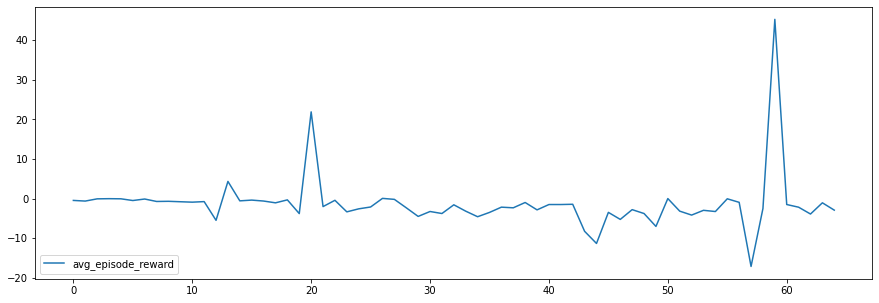

Initial index: 157


In [ ]:
for ep in np.arange(ep, episodes+1):    
    
    idx = np.random.randint(0, n_obs-size-2)
    print('Initial index:', idx)
    
    env.reset()
    env.current_step = idx
    obs = env._next_observation()
    
    done = False
    episode_reward = []
    steps = 0
    
    ##################################################
    
    while not done:    
        
        agent_obs = predictor.predict(obs)
        
        if total_steps == starting_step:
            print('Begin training')
            training = True
            
        if not training:
            action = env.action_space.sample()
        else:
            action = agent.select_action(agent_obs)
            
            if expl_noise != 0:
                noise = np.random.normal(0, expl_noise, size=env.action_space.shape[0])
                action = (action+noise).clip(env.action_space.low, env.action_space.high)
                
        action_fmt = env.format_action(positions, action)
                
        new_obs, reward, done, info = env.step(action_fmt)
        done |= (steps >= size)
        
        episode_reward.append(reward)
        predictor.commit(obs, new_obs)        
        
        agent_new_obs = predictor.predict(new_obs)
        agent.replay_buffer.add((agent_obs, agent_new_obs, action, reward, int(done)))
                
        obs = new_obs
        steps += 1
        total_steps += 1
        
    ##################################################
        
    agent.train(steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_freq)
    predictor.train(batch_size)
    
    reward_trace['net_worth_diff'].append(sum(np.array(env.net_worth)-np.array(env.net_worth_long)))
    reward_trace['avg_episode_reward'].append(np.mean(episode_reward))
    reward_trace['sum_episode_reward'].append(sum(episode_reward))
    reward_trace['exploration_noise'].append(round(expl_noise, 9))
    
    ax = live_plot(reward_trace, trace='avg')
    plt.show()
    
    if ep % REPORT == 0:
         
        print('Episode number:', int(ep))
        print('Net-worth difference:', reward_trace['net_worth_diff'][-1])
        print('Average reward:', reward_trace['avg_episode_reward'][-1])
        time.sleep(0.5)
        
        agent.save(
            f'{file_name}_{int(ep)}', 
            './models/all_td3',
        )
        
        predictor.save(
            f'{file_name}_{int(ep)}', 
            './models/all_td3',
        )
        

In [ ]:
ep

##### Plot reward trace

In [ ]:
nwd = pd.Series(reward_trace['net_worth_diff'])
nwd = nwd.rolling(window=REPORT, center=True, min_periods=1).mean()

print(np.argmax(nwd)+1, np.argmax(reward_trace['net_worth_diff'])+1)

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['net_worth_diff'], 'b', alpha=0.7)
plt.plot(nwd, 'b')
plt.axvline(0, c='r')

plt.show()

In [ ]:
lr = LinearRegression()

X = np.arange(1, len(reward_trace['avg_episode_reward'])+1).reshape(-1,1)
y = np.array(reward_trace['avg_episode_reward']).reshape(-1,1)

lr.fit(X, y)

def f(x): return lr.intercept_[0] + np.dot(x.reshape(-1,1), lr.coef_)
print(lr.coef_[0])

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['avg_episode_reward'], 'b')
plt.plot(f(np.arange(len(reward_trace['avg_episode_reward']))), '--r', alpha=0.7)
plt.axvline(0, c='r')

plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['sum_episode_reward'], 'b')
plt.axvline(0, c='r')

plt.show()

---
---
---

### Save model:

In [ ]:
idx = 950

In [ ]:
agent.load(
    f'{file_name}_{idx}', 
    './models/all_td3',
)

predictor.load(
    f'{file_name}_{idx}', 
    './models/all_td3',
)


In [ ]:
agent.save(
    file_name, 
    './models',
)

predictor.save(
    file_name, 
    './models',
)


In [ ]:
for item in os.listdir('./models/all_td3'):
    if file_name in str(item):
        os.remove(os.path.join('./models/all_td3', item))
        
print(file_name)